from
https://huggingface.co/docs/transformers/training


In [1]:
!conda info 



     active environment : DL-torch-arm64
    active env location : /Applications/anaconda3/envs/DL-torch-arm64
            shell level : 2
       user config file : /Users/antoineherbet/.condarc
 populated config files : /Users/antoineherbet/.condarc
          conda version : 24.7.1
    conda-build version : 24.5.1
         python version : 3.12.2.final.0
                 solver : libmamba (default)
       virtual packages : __archspec=1=m1
                          __conda=24.7.1=0
                          __osx=14.5=0
                          __unix=0=0
       base environment : /Applications/anaconda3  (writable)
      conda av data dir : /Applications/anaconda3/etc/conda
  conda av metadata url : None
           channel URLs : https://conda.anaconda.org/conda-forge/osx-arm64
                          https://conda.anaconda.org/conda-forge/noarch
                          https://repo.anaconda.com/pkgs/main/osx-arm64
                          https://repo.anaconda.com/pkgs/main/n

In [2]:
import torch
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    device = torch.device("mps")

In [3]:
torch.backends.mps.is_available()

True

In [4]:
# training a model

from datasets import load_dataset

dataset = load_dataset("yelp_review_full")
dataset["train"][100]

{'label': 0,
 'text': 'My expectations for McDonalds are t rarely high. But for one to still fail so spectacularly...that takes something special!\\nThe cashier took my friends\'s order, then promptly ignored me. I had to force myself in front of a cashier who opened his register to wait on the person BEHIND me. I waited over five minutes for a gigantic order that included precisely one kid\'s meal. After watching two people who ordered after me be handed their food, I asked where mine was. The manager started yelling at the cashiers for \\"serving off their orders\\" when they didn\'t have their food. But neither cashier was anywhere near those controls, and the manager was the one serving food to customers and clearing the boards.\\nThe manager was rude when giving me my order. She didn\'t make sure that I had everything ON MY RECEIPT, and never even had the decency to apologize that I felt I was getting poor service.\\nI\'ve eaten at various McDonalds restaurants for over 30 years. 

In [5]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-cased")


def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)


tokenized_datasets = dataset.map(tokenize_function, batched=True)

In [6]:
tokenized_datasets = tokenized_datasets.remove_columns(["text"])

In [7]:
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")

In [8]:
tokenized_datasets.set_format("torch")

In [9]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(1000))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(1000))

In [10]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(small_train_dataset, shuffle=True, batch_size=8)
eval_dataloader = DataLoader(small_eval_dataset, batch_size=8)

In [11]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-cased", num_labels=5)

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [12]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

In [13]:
from transformers import get_scheduler

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [14]:
#import torch

#device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [15]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

  0%|          | 0/375 [00:00<?, ?it/s]

In [16]:
import evaluate

metric = evaluate.load("accuracy")
model.eval()
for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

metric.compute()

{'accuracy': 0.586}

In [17]:
# creating a tensor and push it to the device

x = torch.zeros(2,3)
x = x.to(device)
print("X",x)

X tensor([[0., 0., 0.],
        [0., 0., 0.]], device='mps:0')


device is working



In [18]:
import time
x = torch.randn(5000, 5000)

## CPU version
start_time = time.time()
_ = torch.matmul(x, x)
end_time = time.time()
print(f"CPU time: {(end_time - start_time):6.5f}s")

## GPU version
x = x.to(device)
_ = torch.matmul(x, x)  # First operation to 'burn in' GPU
# CUDA is asynchronous, so we need to use different timing functions
start = torch.mps.Event(enable_timing=True)
end = torch.mps.Event(enable_timing=True)
start.record()
_ = torch.matmul(x, x)
end.record()
torch.mps.synchronize()  # Waits for everything to finish running on the GPU
print(f"GPU time: {0.001 * start.elapsed_time(end):6.5f}s")  # Milliseconds to seconds

CPU time: 0.43933s
GPU time: 0.30468s


# Continous XOR example:

If we want to build a neural network in PyTorch, we could specify all our parameters (weight matrices, bias vectors) using Tensors (with requires_grad=True), ask PyTorch to calculate the gradients and then adjust the parameters. But things can quickly get cumbersome if we have a lot of parameters. In PyTorch, there is a package called torch.nn that makes building neural networks more convenient.

We will introduce the libraries and all additional parts you might need to train a neural network in PyTorch, using a simple example classifier on a simple yet well known example: XOR. Given two binary inputs  𝑥1  and  𝑥2 , the label to predict is  1  if either  𝑥1  or  𝑥2  is  1  while the other is  0 , or the label is  0  in all other cases. The example became famous by the fact that a single neuron, i.e. a linear classifier, cannot learn this simple function. Hence, we will learn how to build a small neural network that can learn this function. To make it a little bit more interesting, we move the XOR into continuous space and introduce some gaussian noise on the binary inputs. Our desired separation of an XOR dataset could look as follows:

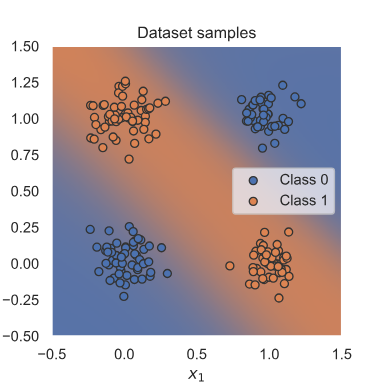

## The model

Let's find the useful classes in the torch.nn package. 

In [19]:
import torch.nn as nn

It also exists torch.nn.functional. It contains functions that are used in network layers. This is in contrast to torch.nn which defines them as nn.Modules and torch.nn actually uses a lot of functionalities from torch.nn.functional. As it is useful we import it as well.

In [20]:
import torch.nn.functional as F

### nn.Module
In PyTorch, a neural network is built up out of modules. Modules can contain other modules, and a neural network is considered to be a module itself as well. The basic template of a module is as follows:


In [21]:
class MyModule(nn.Module):

    def __init__(self):
        super().__init__()
        # Some init for my module

    def forward(self, x):
        # Function for performing the calculation of the module.
        pass

the forward function is were the computation of the module is taking place and is executed when you call the module. In the init function, we usually create the parameters of the module, using nn.Parameter, or defining other modules that are used in the forward function. The backward calculation is done automatically, but could be overwritten as well if wanted. 

Let's now create our own pre-defined modules in the torch.nn package and then our NN. Let's use a minima network with an input layer with 2 neurons, one hidden layer with 4 neurons and tanh as activation function and a output layer with 1 neuron.

In [22]:
class SimpleClassifier(nn.Module):

    def __init__(self, num_inputs, num_hidden, num_outputs):
        super().__init__()
        # Initialize the modules we need to build the network
        self.linear1 = nn.Linear(num_inputs, num_hidden)
        self.act_fn = nn.Tanh()
        self.linear2 = nn.Linear(num_hidden, num_outputs)

    def forward(self, x):
        # Perform the calculation of the model to determine the prediction
        x = self.linear1(x)
        x = self.act_fn(x)
        x = self.linear2(x)
        return x

For the examples in this notebook, we will use a tiny neural network with two input neurons and four hidden neurons. As we perform binary classification, we will use a single output neuron. Note that we do not apply a sigmoid on the output yet. This is because other functions, especially the loss, are more efficient and precise to calculate on the original outputs instead of the sigmoid output. We will discuss the detailed reason later.

In [23]:
model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1)
# printing a module shows all its submodules
print(model)

SimpleClassifier(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)


To obtain the parameters of a module, we can call paremeters() functions or named_parameters().

In [24]:
for name, param in model.named_parameters():
    print(f"Parameter {name}, shampe{param.shape}")

Parameter linear1.weight, shampetorch.Size([4, 2])
Parameter linear1.bias, shampetorch.Size([4])
Parameter linear2.weight, shampetorch.Size([1, 4])
Parameter linear2.bias, shampetorch.Size([1])


Each linear layer has a weight matrix of the shape [output, input], and a bias of the shape [output]. The tanh activation function does not have any parameters. Note that parameters are only registered for nn.Module objects that are direct object attributes, i.e. self.a = .... If you define a list of modules, the parameters of those are not registered for the outer module and can cause some issues when you try to optimize your module. There are alternatives, like nn.ModuleList, nn.ModuleDict and nn.Sequential, that allow you to have different data structures of modules. We will use them in a few later tutorials and explain them there.

### Data
PyTorch provides a few functionalities to load the training and test data efficiently, summarized in the package torch.utils.data

In [25]:
import torch.utils.data as data

The data package defines two classes which are the standard interface for handling data in PyTorch: data.Dataset, and data.DataLoader. The dataset class provides an uniform interface to access the training/test data, while the data loader makes sure to efficiently load and stack the data points from the dataset into batches during training.

#### The dataset class

The dataset class summarizes the basic functionality of a dataset in a natural way. To define a dataset in PyTorch, we simply specify two functions: __getitem__, and __len__. The get-item function has to return the  𝑖 -th data point in the dataset, while the len function returns the size of the dataset. For the XOR dataset, we can define the dataset class as follows:

In [26]:
class XORDataset(data.Dataset):
    def __init__(self, size, std=0.1):
        """
        Inputs: 
            size - Number of data points we want to generate
            std - Standard deviation of the noise (see generate_continous_xor function)
        """
        super().__init__()
        self.size = size
        self.std = std
        self.generate_continuous_xor()

    def generate_continuous_xor(self):
        # Each data point in the XOR dataset has two variables, x and y that can be either 0 or 1
        # The label is their XOR combination, ie 1 if only x or only y is 1 while the other is 0.
        # If x=y, the label is 0.
        data = torch.randint(low=0, high=2, size=(self.size,2), dtype=torch.float32)
        label = (data.sum(dim=1) == 1).to(torch.long)
        # To make it slightly more challenging, we add a bit of gaussian noise to the data points.
        data += self.std * torch.randn(data.shape)

        self.data = data
        self.label = label

    def __len__(self):
        # Number of data point we have. Alternatively self.data.shape[0], or self.label.shape[0]
        return self.size

    def __getitem__(self, idx):
        # Return the idx-th data point of the dataset
        # if we have multiple things to return (data point and label), we can return them as tuple
        data_point=self.data[idx]
        data_label=self.label[idx]
        return data_point,data_label

Let's try to create such a dataset and inspect it:

In [27]:
dataset = XORDataset(size=200)
print(f"Size of dataset", len(dataset))
print(f"Data point 0:", dataset[0])

Size of dataset 200
Data point 0: (tensor([0.0202, 1.0256]), tensor(1))


To better relate the dataset, we visualize the samples below:

In [28]:
def visualize_samples(data,label):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    plt.figure(figsize=(4,4))
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()
    


In [29]:
## Imports for plotting
import matplotlib.pyplot as plt
import matplotlib_inline
%matplotlib inline
from IPython.display import set_matplotlib_formats
matplotlib_inline.backend_inline.set_matplotlib_formats('svg','pdf')
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

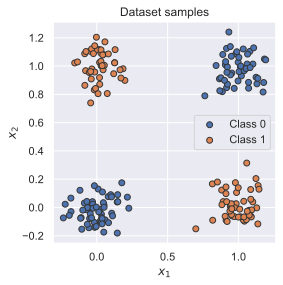

In [30]:
visualize_samples(dataset.data, dataset.label)
plt.show()

#### The data loader class

The class torch.utils.data.DataLoader represents a Python iterable over a dataset with support for automatic batching, multi-process data loading and many more features. The data loader communicates with the dataset using the function __getitem__, and stacks its outputs as tensors over the first dimension to form a batch. In contrast to the dataset class, we usually don't have to define our own data loader class, but can just create an object of it with the dataset as input. Additionally, we can configure our data loader with the following input arguments (only a selection, see full list here):

- __batch_size__: Number of samples to stack per batch
- __shuffle__: If True, the data is returned in a random order. This is important during training for introducing stochasticity.
- __num_workers__: Number of subprocesses to use for data loading. The default, 0, means that the data will be loaded in the main process which can slow down training for datasets where loading a data point takes a considerable amount of time (e.g. large images). More workers are recommended for those, but can cause issues on Windows computers. For tiny datasets as ours, 0 workers are usually faster.
- __pin_memory__: If True, the data loader will copy Tensors into CUDA pinned memory before returning them. This can save some time for large data points on GPUs. Usually a good practice to use for a training set, but not necessarily for validation and test to save memory on the GPU.
- __drop_last__: If True, the last batch is dropped in case it is smaller than the specified batch size. This occurs when the dataset size is not a multiple of the batch size. Only potentially helpful during training to keep a consistent batch size.
Let's create a simple data loader below:

In [31]:
data_loader = data.DataLoader(dataset, batch_size=8, shuffle=True, 
                             num_workers = 0,
                             pin_memory = True, # good for training dataset but not validate and test
                             drop_last = False # put true see up
                             )

In [32]:
# next(iter(...)) catches the first batch of the data loader
# If shuffle is True, this will return a different batch every time we run this cell
# For iterating over the whole dataset, we can simple use "for batch in data_loader: ..."
data_inputs, data_labels = next(iter(data_loader))

# The shape of the outputs are [batch_size, d_1,...,d_N] where d_1,...,d_N are the
# dimensions of the data point returned from the dataset class
print("Data inputs", data_inputs.shape, "\n", data_inputs)
print("Data labels", data_labels.shape, "\n", data_labels)

Data inputs torch.Size([8, 2]) 
 tensor([[ 8.8958e-01,  1.0818e+00],
        [ 3.2823e-02, -4.6755e-02],
        [ 9.7348e-01, -9.6734e-04],
        [ 1.0341e+00,  1.1207e+00],
        [-8.3834e-02,  8.6356e-01],
        [ 1.0208e+00,  9.3046e-01],
        [ 1.1739e+00,  8.1637e-01],
        [ 4.0492e-02,  1.0938e-01]])
Data labels torch.Size([8]) 
 tensor([0, 0, 1, 0, 1, 0, 0, 0])


### Optimization

After defining the model and the dataset, it is time to prepare the optimization of the model. During training, we will perform the following steps:

Get a batch from the data loader
Obtain the predictions from the model for the batch
Calculate the loss based on the difference between predictions and labels
Backpropagation: calculate the gradients for every parameter with respect to the loss
Update the parameters of the model in the direction of the gradients
We have seen how we can do step 1, 2 and 4 in PyTorch. Now, we will look at step 3 and 5.

### Loss modules

We can calculate the loss for a batch by simply performing a few tensor operations as those are automatically added to the computation graph. For instance, for binary classification, we can use Binary Cross Entropy (BCE) which is defined as follows:

𝐵𝐶𝐸=−∑𝑖[𝑦𝑖log𝑥𝑖+(1−𝑦𝑖)log(1−𝑥𝑖)]

where 𝑦 are our labels, and 𝑥 our predictions, both in the range of [0,1]. However, PyTorch already provides a list of predefined loss functions which we can use (see here for a full list). For instance, for BCE, PyTorch has two modules: nn.BCELoss(), nn.BCEWithLogitsLoss(). While nn.BCELoss expects the inputs 𝑥 to be in the range [0,1], i.e. the output of a sigmoid, nn.BCEWithLogitsLoss combines a sigmoid layer and the BCE loss in a single class. This version is numerically more stable than using a plain Sigmoid followed by a BCE loss because of the logarithms applied in the loss function. Hence, it is adviced to use loss functions applied on "logits" where possible (remember to not apply a sigmoid on the output of the model in this case!). For our model defined above, we therefore use the module nn.BCEWithLogitsLoss.

In [33]:
loss_module = nn.BCEWithLogitsLoss()

### Stochastic Gradient Descent

Package __torch.optim__ is the most popular optimizers implemented. For now let's use the simplest one: __torch.optim.SGD__


In [34]:
# input to the optimizer are the parameters of the model: model.parameters()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

The optimizer provides two useful functions: __optimizer.step()__ and __optimizer.zero_grad()__. 
The step function updates the parameters based on the gradients. The zero_grad function sets the gradients of all parameters to zero. It is a crucial pre-step before performing backpropagation. 
If we call the __backward__ function on the loss while the parameter gradients are non-zero from the previous batch, the new gradients would actually be added to the previous ones instead of overwritting them. This is done because a parameter might occur multiple times in a computation graph and we need to sum the gradients in this case instead of replacing them. Hence, remember to call __optimizer.zero_grad()__ before calculating the gradients of a batch. 

### Training

Finally, we are ready to train our model. 

In [35]:
train_dataset = XORDataset(size=2500)
train_data_loader = data.DataLoader(train_dataset, batch_size = 128, shuffle = True)


Now we can write a small training function. Remember our five steps: 
- load a batch
- obtain the predictions
- calculate the loss
- backpropagate
- update
Additionnaly, we have to push all data and model and model parameters to the device of our choice (GPU is available). For the tiny neural netword we have, communicating the data to the GPU actually takes much more time than we could save from running the operation on GPU.
For large networkds, the communication time is significantly smaller than the actual runtime making a GPU crucial in the cases. Still, to practice, we will push the data to GPU here.

In [36]:
# push the model to device. Has to be done only once
# here it is mute because it was already done at the beginning of the project
model.to(device)
print(device)

mps


In addition, we set our model to training mode. This is done by calling __model.train()__. There exist certain modules that need to perform a different forward step during training than during testing (BatchNorm and Dropout) and we can switch between them using __model.train()__ and __model.eval()__.active_adapter

In [37]:
def train_model(model, optimizer, data_loader, loss_module, num_epochs= 100):
    # set model to train mmode
    model.train()

    # training loop
    for epoch in tqdm(range(num_epochs)):
        for data_inputs, data_labels in data_loader:

            ## step 1: move input data to device (only strictly necessary if we use GPU)
            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)

            ## step 2: run the model on the input data
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1) # output is [Batch size , 1] but we want [ Batch size]

            ## step 3: calculate the loss
            loss = loss_module(preds, data_labels.float())

            ## step 4: perform backpropagation
            # before calculating the gradients, we need to endure that they are all zero
            # The gradients would not be overwritten, but actually added to the existing ones
            optimizer.zero_grad() 
            # performan backpropagation 
            loss.backward() 

            ## step 5: update the parameters
            optimizer.step()


            

In [38]:
train_model(model, optimizer, train_data_loader, loss_module)

  0%|          | 0/100 [00:00<?, ?it/s]

### Saving a model 

After finish training a model, we save the model to disk so that we can load the same weights at a later time. For this, we extract the so-called __state_dict__ from the model which contains all learnable parameters. 

In [39]:
state_dict = model.state_dict() 
print(state_dict)

OrderedDict([('linear1.weight', tensor([[-3.2273,  2.2318],
        [-3.2714, -2.8111],
        [ 0.8767, -2.6947],
        [ 0.9176, -0.0897]], device='mps:0')), ('linear1.bias', tensor([-0.8955,  0.9626,  0.2964,  0.3148], device='mps:0')), ('linear2.weight', tensor([[ 3.5306, -4.0643,  3.5148, -0.6117]], device='mps:0')), ('linear2.bias', tensor([0.1723], device='mps:0'))])


To save the state dictionary, we can use __torch.save__

In [40]:
# torch.save(object, filename). for the filename any extension can be used 
torch.save(state_dict, "model.dlcourse1")

To load a model from a state dict, we use the function __torch.load__ to load the state dict fro the disk and the module function load_state_dict to overwrite our parameters with the new values:

In [41]:
# load state dict from the disk:
state_dict = torch.load("model.dlcourse1")

# create a new model and load the state
new_model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1)
new_model.load_state_dict(state_dict)

# verify that the parameters are the same
print("Original model\n", model.state_dict())
print("\nLoaded model\n", new_model.state_dict())

Original model
 OrderedDict([('linear1.weight', tensor([[-3.2273,  2.2318],
        [-3.2714, -2.8111],
        [ 0.8767, -2.6947],
        [ 0.9176, -0.0897]], device='mps:0')), ('linear1.bias', tensor([-0.8955,  0.9626,  0.2964,  0.3148], device='mps:0')), ('linear2.weight', tensor([[ 3.5306, -4.0643,  3.5148, -0.6117]], device='mps:0')), ('linear2.bias', tensor([0.1723], device='mps:0'))])

Loaded model
 OrderedDict([('linear1.weight', tensor([[-3.2273,  2.2318],
        [-3.2714, -2.8111],
        [ 0.8767, -2.6947],
        [ 0.9176, -0.0897]])), ('linear1.bias', tensor([-0.8955,  0.9626,  0.2964,  0.3148])), ('linear2.weight', tensor([[ 3.5306, -4.0643,  3.5148, -0.6117]])), ('linear2.bias', tensor([0.1723]))])



### Evaluation

Once we have trained a model, it is time to evaluate it on a held-out test set. As our dataset consist of randomly generated data points, we need to first create a test wet with a corresponding data loader:

In [42]:
test_dataset = XORDataset(size = 500)
# drop_last —> Don't drop the last batch although it is smaller than 128abs
test_data_loader = data.DataLoader(test_dataset, batch_size=128, shuffle=False, drop_last=False)


As metric we will use __accuracy__
When evaluating the model, we don't need to keep track of the computation graph as we don't intend to calculate the gradients. This reduces the required memory and speed up the model. In PyTorch, we can deactivate the computation graphi using __with torch.no_grad()__:. Don't forget to set the model to eval mode.

In [43]:
def eval_model(model, data_loader):
    model.eval() # set model to eval mode 
    true_preds, num_preds = 0.,0.

    with torch.no_grad(): # deactivate gradients for the following code 
        for data_inputs, data_labels in data_loader:

            # determine prediction of model on dev set:
            data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1)
            preds = torch.sigmoid(preds) # sigmoid to map predictions between 0 and 1
            preds_labels = (preds >=0.5).long() # binarize predictions to 0 and 1

            # keep records of predictions for the accuracy metric (true_preds = TP+TN, num_preds = TP+TN+FP+FN)
            true_preds += (preds_labels == data_labels).sum()
            num_preds += data_labels.shape[0]

        acc = true_preds / num_preds
        print(f"Accuracy of the model: {100.0 * acc :4.2f}%")



In [44]:
eval_model(model, test_data_loader)

Accuracy of the model: 100.00%


If we trained our model correctly, we should see a score close to 100%. However, this is only possible because of our simple task and unfortunaly, we usually don't get high scores on test sets of more complex tasks. 


### Visualizing classification boundaries

To visualize what our model has learned, we can perform a prediction for every data point in a range of  [−0.5,1.5] , and visualize the predicted class as in the sample figure at the beginning of this section. This shows where the model has created decision boundaries, and which points would be classified as  0 , and which as  1 . We therefore get a background image out of blue (class 0) and orange (class 1). The spots where the model is uncertain we will see a blurry overlap. The specific code is less relevant compared to the output figure which should hopefully show us a clear separation of classes:

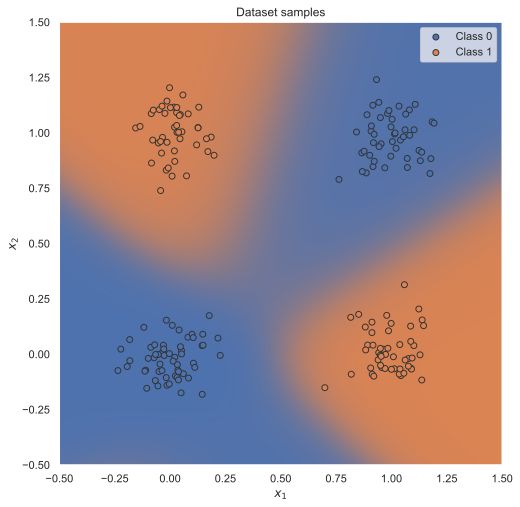

In [45]:
@torch.no_grad() # Decorator, same effect as "with torch.no_grad(): ..." over the whole function.
def visualize_classification(model, data, label):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    fig = plt.figure(figsize=(8,8), dpi=500)
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

    # Let's make use of a lot of operations we have learned above
    model.to(device)
    c0 = torch.Tensor(to_rgba("C0")).to(device)
    c1 = torch.Tensor(to_rgba("C1")).to(device)
    x1 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    x2 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    xx1, xx2 = torch.meshgrid(x1, x2, indexing='ij')  # Meshgrid function as in numpy
    model_inputs = torch.stack([xx1, xx2], dim=-1)
    preds = model(model_inputs)
    preds = torch.sigmoid(preds)
    output_image = (1 - preds) * c0[None,None] + preds * c1[None,None]  # Specifying "None" in a dimension creates a new one
    output_image = output_image.cpu().numpy()  # Convert to numpy array. This only works for tensors on CPU, hence first push to CPU
    plt.imshow(output_image, origin='lower', extent=(-0.5, 1.5, -0.5, 1.5))
    plt.grid(False)
    return fig

_ = visualize_classification(model, dataset.data, dataset.label)
plt.show()


The decision boundaries might not look exactly as in the figure in the preamble of this section which can be caused by running it on CPU or a different GPU architecture. Nevertheless, the result on the accuracy metric should be the approximately the same.

## Additional features we didn't get to discuss yet:

Finally, you are all set to start with your own PyTorch project! In summary, we have looked at how we can build neural networks in PyTorch, and train and test them on data. However, there is still much more to PyTorch we haven't discussed yet. In the coming series of Jupyter notebooks, we will discover more and more functionalities of PyTorch, so that you also get familiar to PyTorch concepts beyond the basics. If you are already interested in learning more of PyTorch, we recommend the official tutorial website that contains many tutorials on various topics. Especially logging with Tensorboard (official tutorial here) is a good practice that we will explore in our small example.

### TensorBoard logging

TensorBoard is a logging and visualization tool that is a popular choice for training DL models. Although initially published for TensorFlow, TensorBoard is also integrated in PyTorch allowing us to easily use it. First, let's import it below:

In [46]:
# Import tensorboard logger from PyTorch
from torch.utils.tensorboard import SummaryWriter

# load tensorboard extention for jupyter notebook, only need to start TB in the notebook
%load_ext tensorboard

The last line is required if you want to run TensorBoard directly in the Jupyter Notebook. Otherwise, you can start TensorBoard from the terminal.

PyTorch's TensorBoard API is simple to use. We start the logging process by creating a new object, __writer = SummaryWriter(...)__, where we specify the directory in which the logging file should be saved. With this object, we can log different aspects of our model by calling functions of the style __writer.add_...___. For example, we can visualize the computation graph with the function writer.add_graph, or add a scalar value like the loss with __writer.add_scalar__. Let's adapt our initial training function with adding a TensorBoard logger below.

In [47]:
def train_model_with_logger(model, optimizer, data_loader, loss_module, val_dataset, num_epochs=100, logging_dir='runs/our_experiment'):
    # Create TensorBoard logger
    writer = SummaryWriter(logging_dir)
    model_plotted = False

    # Set model to train mode
    model.train()

    # Training loop
    for epoch in tqdm(range(num_epochs)):
        epoch_loss = 0.0
        for data_inputs, data_labels in data_loader:

            ## Step 1: Move input data to device (only strictly necessary if we use GPU)
            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)

            # For the very first batch, we visualize the computation graph in TensorBoard
            if not model_plotted:
                writer.add_graph(model, data_inputs)
                model_plotted = True

            ## Step 2: Run the model on the input data
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]

            ## Step 3: Calculate the loss
            loss = loss_module(preds, data_labels.float())

            ## Step 4: Perform backpropagation
            # Before calculating the gradients, we need to ensure that they are all zero.
            # The gradients would not be overwritten, but actually added to the existing ones.
            optimizer.zero_grad()
            # Perform backpropagation
            loss.backward()

            ## Step 5: Update the parameters
            optimizer.step()

            ## Step 6: Take the running average of the loss
            epoch_loss += loss.item()

        # Add average loss to TensorBoard
        epoch_loss /= len(data_loader)
        writer.add_scalar('training_loss',
                          epoch_loss,
                          global_step = epoch + 1)

        # Visualize prediction and add figure to TensorBoard
        # Since matplotlib figures can be slow in rendering, we only do it every 10th epoch
        if (epoch + 1) % 10 == 0:
            fig = visualize_classification(model, val_dataset.data, val_dataset.label)
            writer.add_figure('predictions',
                              fig,
                              global_step = epoch + 1)

    writer.close()

Let's now use this method to train a model as before with a new model and optimizer:

In [48]:
model = SimpleClassifier(num_inputs = 2, num_hidden = 4, num_outputs = 1).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
train_model_with_logger(model, optimizer, train_data_loader, loss_module, val_dataset=dataset)

  0%|          | 0/100 [00:00<?, ?it/s]

The tensorBoard file in the folder __run/our_experiment__ now contains a loss curve, the computation graph of our network and a visualization of the learned predictions over number of epochs. To start the TensorBoard visualizer, simply run the following statement:

In [49]:
%tensorboard --logdir runs/

Tensorboard visualizations can help to identify possible issues with your model and identify situations such as overfitting. You can also track the training progress while a model is training, since the logger automatically writes everything added to it to the logging file. Feel free to explore the TensorBoard functionalities. 